## Coding Test
### Energy consumption prediction model

#### Submitted by Samuel Desrosiers

<br><br><br>


Predicting energy needs represent a key asset for both businesses and institutions. It can lead to better peak usage minimization and allows for better infrastructures and planning from electricty companies.

These predictions also present key advantages to consumers and companies. It can allow for better identification of abnormal energy consumption that could mean some dysunction the appliances and electrical systems. Good model insight could help identify key factor in importance for consumption prediction and potential points of optimization. 

The interconnectedness of the energy sector to other industry sectors means great cumulative even for a modest model.


Time series present a lot of documented risks. Time series data can hide a lot of hidden variables and context through time dependencies. This can be a cause of pattern shifting and limits the universality of the trained model. Another important risk is data leakage, where the efficiency of the model could be overestimated, as recent data is used to train a model that could be tested on earlier data. 

-------------------------------------------------------------------------------------------
<br>

A quick tour of the litterature shows there are different approaches leading to good results.

Support for GBM:

https://www.degruyterbrill.com/document/doi/10.1515/dema-2022-0176/html?lang=en


Quantile regression and socio-economic effects:
https://www.sciencedirect.com/science/article/pii/S0360544215005873?casa_token=hpXJNH2SiGcAAAAA:48fL5U_uSCIeNZgVu-bUd9yy1ds0HAlAWmZTuZ7g51_ELGREoFG6AG1wabHWJWxHgUxs6NKwQ1w


RNN:
https://www.sciencedirect.com/science/article/pii/S1364032107000664?casa_token=Ngz-DCL9YbMAAAAA:vFCHX3_NQIV_7zqUktAJeHReOi3q3q5AxU9IoHaItPWxvElF3CoHVa7xM2dVO7HAcBQB9iM4IUQ


<br>

The simplicity of use and training would probably make GBM methods a good candidate. XGBoost is mentionned in the litterature and on online forums for similar problems:


https://ithy.com/article/xgboost-energy-prediction-guide-fr-qaltra7z

https://ieeexplore.ieee.org/document/10176934

https://medium.com/@ethannabatchian/exploring-time-series-prediction-of-energy-consumption-using-xgboost-and-cross-validation-5d299655bec6


This would make it easier to pick-up. Of course, the quality of the data and correlations with features will have an impact on the choice of model and parameter choices. 


-------------------------------------------------------------------------------------------
<br>

*Note: For time constraints reasons, proper docstring and typing was not made here. I usually use Google docstring.*



<br>

Let's now have a look at the actual data.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def load_dataframe(path):
    df = pd.read_csv(path)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])

    return df


df = load_dataframe(path="dataset_1.csv")


### Part One:

## Pre-modelling analysis

In [3]:
# Let's first verify if there are any worrying patterns in the missing data of the file.


def missing_data_summary(df):
    missing_summary = pd.DataFrame(
        {
            "Missing_Count": df.isnull().sum(),
            "Missing_Percentage": (df.isnull().sum() / len(df) * 100).round(2),
            "Max_Missing_Streak": [
                df[col]
                .isnull()
                .groupby((df[col].isnull() != df[col].isnull().shift()).cumsum())
                .sum()
                .max()
                for col in df.columns
            ],
        }
    )
    missing_summary = missing_summary[missing_summary["Missing_Count"] > 0].sort_values(
        "Missing_Percentage", ascending=False
    )

    return missing_summary


missing_data_summary(df)


,Missing_Count,Missing_Percentage,Max_Missing_Streak
RH_7,3954,22.45,1152
T8,3774,21.43,1153
T6,3529,20.04,1152
T7,3434,19.50,1152
T2,3430,19.48,1152
T3,3337,18.95,1152
RH_1,3302,18.75,1152
T1,3296,18.72,1152
RH_4,3222,18.30,1152
RH_9,3187,18.10,1152


In [4]:
# These numbers seem really high, it seems like even the target data (Appliances) is missing in a lot of rows.
# Let's eliminate any large block of mostly missing data, and data with missing target value.


def remove_sparse_blocks(df, min_block_size, missing_threshold):

    # Find consecutive groups of high missing rows
    missing_pct_per_row = df.isnull().sum(axis=1) / len(df.columns)
    high_missing_rows = missing_pct_per_row > missing_threshold
    groups = (high_missing_rows != high_missing_rows.shift()).cumsum()

    # Count consecutive high missing rows for each group
    group_sizes = high_missing_rows.groupby(groups).agg(["sum", "first"])

    # Find groups that are both high missing AND meet minimum block size
    blocks_to_remove = group_sizes[
        (group_sizes["first"] == True) & (group_sizes["sum"] >= min_block_size)
    ]

    # Get indices of rows to remove
    rows_to_remove = []
    for group_id in blocks_to_remove.index:
        group_mask = groups == group_id
        rows_to_remove.extend(df.index[group_mask].tolist())

    # Remove the identified rows
    cleaned_df = df.copy()
    cleaned_df = cleaned_df.drop(rows_to_remove)

    print(f"Removed {len(rows_to_remove)} rows in {len(blocks_to_remove)} blocks")
    print(f"Original shape: {df.shape}, New shape: {cleaned_df.shape}")

    return cleaned_df, rows_to_remove


def remove_no_target_rows(df):
    cleaned_df = df.copy()

    # Keeping track of removed rows
    removed_indices = df[df["Appliances"].isnull()].index.tolist()
    cleaned_df = cleaned_df.drop(removed_indices)

    print(f"Removed {len(removed_indices)} rows.")
    print(f"Original shape: {df.shape}, New shape: {cleaned_df.shape}")

    return cleaned_df, removed_indices


# Let's check again what are the missing data broadly, now making sure to check the max streak of missing data per column
temp_df, no_target_rows = remove_no_target_rows(df)
temp_df, low_quality_rows = remove_sparse_blocks(temp_df, 3, 0.5)

missing_data_summary(temp_df)


Removed 1151 rows.
Original shape: (17610, 29), New shape: (16459, 29)
Removed 37 rows in 12 blocks
Original shape: (16459, 29), New shape: (16422, 29)


,Missing_Count,Missing_Percentage,Max_Missing_Streak
RH_7,2766,16.84,4
T8,2586,15.75,6
T6,2341,14.26,5
Press_mm_hg,2332,14.20,5
Visibility,2319,14.12,4
T7,2246,13.68,4
T2,2242,13.65,5
T3,2149,13.09,4
RH_1,2114,12.87,4
Windspeed,2108,12.84,4


In [5]:
# Looks like there are still a lot of missing data and potentially time dependent patterns. This must be taken into account in our choice of model.
# For our data analysis prior to training, Let's clean-up missing data via knn and engineer time and environmental features to check for patterns in our data.

from sklearn.impute import KNNImputer


def clean_data_knn(df, n_neighbors=5):
    numeric_cols = df.select_dtypes(include=["number"]).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)

    df_clean = df.copy()
    df_clean[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    return df_clean


def datetime_features(df):
    new_df = df.copy()
    dt = new_df["date"]

    new_df["hour_of_day"] = dt.dt.hour + dt.dt.minute / 60.0 + dt.dt.second / 3600.0

    new_df["day_of_week"] = dt.dt.dayofweek + new_df["hour_of_day"] / 24.0
    start_of_year = dt.apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
    new_df["day_of_year"] = (dt - start_of_year).dt.total_seconds() / (24 * 3600)

    return new_df


def env_features(df):
    new_df = df.copy()

    Ts_inside = ["T1", "T2", "T3", "T4", "T5", "T7", "T8", "T9"]

    new_df["T_inside_avg"] = df[Ts_inside].mean(axis=1)
    new_df["T_range"] = df[Ts_inside].max(axis=1) - df[Ts_inside].min(axis=1)
    new_df["T_diff"] = new_df["T_inside_avg"] - df["T_out"]

    new_df["heating_need"] = np.maximum(0, 18.0 - new_df["T_inside_avg"])
    new_df["cooling_need"] = np.maximum(0, new_df["T_inside_avg"] - 24.0)

    return new_df


temp_df = clean_data_knn(df, 10)
temp_df = datetime_features(temp_df)
temp_df = env_features(temp_df)


In [6]:
# Now let's remove all data for which the knn fit would not be valid.

_, no_target_rows = remove_no_target_rows(df)
_, low_quality_rows = remove_sparse_blocks(df, 3, 0.5)
temp_df = temp_df.drop(index=list(set(no_target_rows + low_quality_rows)))
temp_df.shape


Removed 1151 rows.
Original shape: (17610, 29), New shape: (16459, 29)
Removed 1189 rows in 13 blocks
Original shape: (17610, 29), New shape: (16421, 29)


(16421, 37)

In [7]:
# Let's now see if there are linear correlations

from scipy.stats import pearsonr


def plot_time(df, param, time_type="hour_of_day"):

    plt.scatter(df[time_type], df[param], "bx")
    plt.ylabel(param)
    plt.xlabel(f"time ({time_type})")
    plt.show()


def plot_appliances_histogram(df, bins=50, percentile_limit=None):
    data = df["Appliances"]
    title_suffix = ""
    
    # Calculate weights to convert to percentages
    weights = np.ones_like(data) / len(data) * 100
    
    n, bins, patches = plt.hist(
        data, bins=bins, weights=weights, alpha=0.7, edgecolor="black", color="skyblue"
    )
    
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    
    plt.axvline(
        mean_val,
        color="black",
        linestyle="--",
        alpha=0.8,
        label=f"Mean: {mean_val:.1f} Wh",
    )
    plt.axvline(
        median_val,
        color="orange",
        linestyle="--",
        alpha=0.8,
        label=f"Median: {median_val:.1f} Wh",
    )
    
    plt.xlabel("Appliances Usage (Wh)")
    plt.ylabel("Frequency (%)")  
    plt.title(f"Distribution of Appliances Usage{title_suffix}")
    
    if percentile_limit:
        percentile_val = np.percentile(df["Appliances"], percentile_limit)
        plt.axvline(
            percentile_val,
            color="red",
            linestyle="--",
            alpha=0.8,
            label=f"{percentile_limit}th percentile: {percentile_val:.1f} Wh",
        )
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_appliances_lin(df, param, plot_type="scatter", y_lim=None):
    #Display correlation between features and target visually.
    if plot_type == "scatter":
        plt.scatter(df[param], df["Appliances"], alpha=0.2, s=1)
    elif plot_type == "heatmap":
        plt.hist2d(df[param], df["Appliances"], bins=20, cmap="Blues")
        plt.colorbar(label="Count")
    elif plot_type == "hexbin":
        plt.hexbin(df[param], df["Appliances"], gridsize=30, cmap="Blues", mincnt=1)
        plt.colorbar(label="Count")
    elif plot_type == "boxplot":
        param_bins = pd.cut(df[param], bins=10)
        bin_centers = [(interval.left + interval.right) / 2 
                      for interval in param_bins.cat.categories]
        grouped_data = [df[param_bins == interval]["Appliances"].values 
                       for interval in param_bins.cat.categories]
        bin_widths = [(interval.right - interval.left) * 0.8 
                     for interval in param_bins.cat.categories]
        plt.boxplot(grouped_data, positions=bin_centers, widths=bin_widths, 
                   flierprops=dict(marker='o', alpha=0.3, markersize=2))
        
        # Set custom tick labels showing ranges
        bin_labels = [f"{interval.left:.3f}-{interval.right:.3f}" 
                     for interval in param_bins.cat.categories]
        plt.xticks(bin_centers, bin_labels, rotation=90)
    
    # Correlation line
    z = np.polyfit(df[param], df["Appliances"], 1)
    p = np.poly1d(z)
    plt.plot(df[param], p(df[param]), "r--", alpha=0.8)
    
    # Calculate and display correlation
    r, p_value = pearsonr(df[param], df["Appliances"])
    plt.text(0.05, 0.85, f"r = {r:.3f}\np = {p_value:.3f}",
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    plt.xlabel(param)
    plt.ylabel("Appliances (Wh)")
    plt.title(f"Appliances Usage vs {param}")
    if y_lim:
        plt.ylim(0, y_lim)
    
    # Round x-axis tick values and rotate them 90 degrees (except for boxplot)
    if plot_type != "boxplot":
        current_ticks = plt.xticks()[0]
        rounded_ticks = [round(tick, 3) for tick in current_ticks]
        plt.xticks(current_ticks, rounded_ticks, rotation=90)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return r, p_value


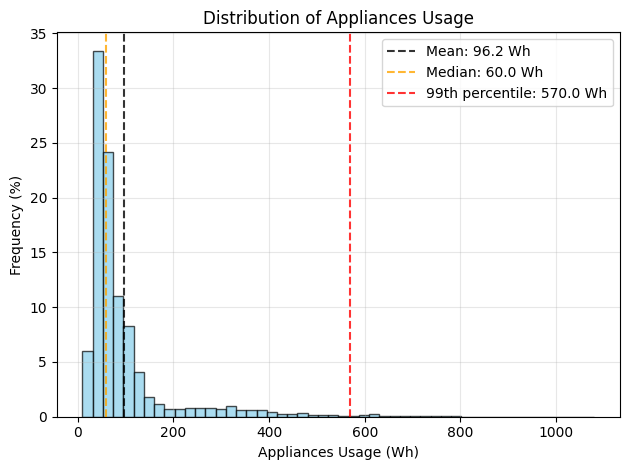

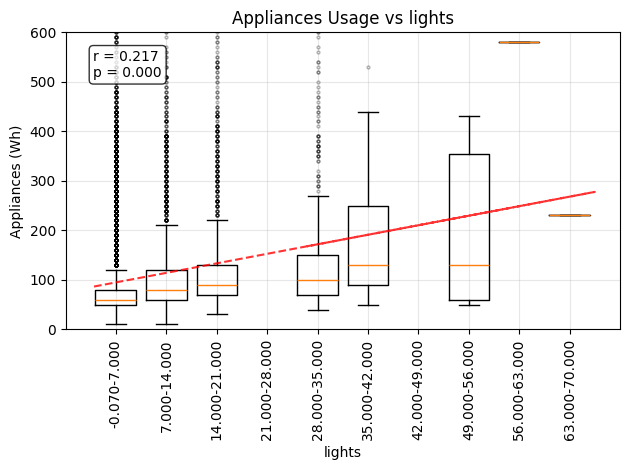

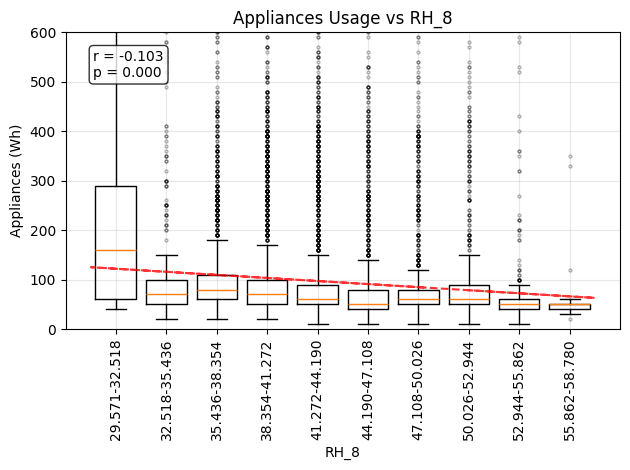

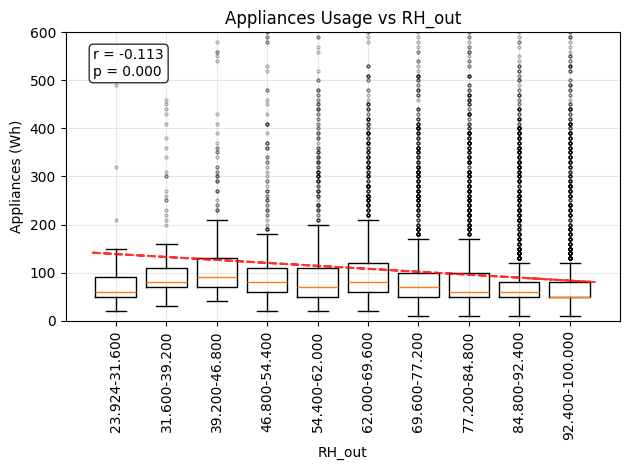

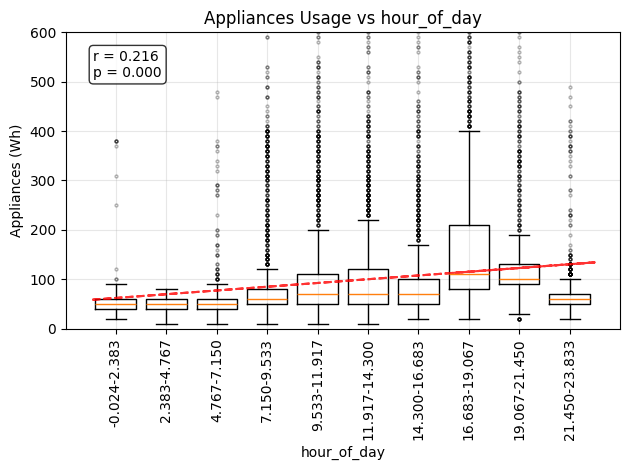

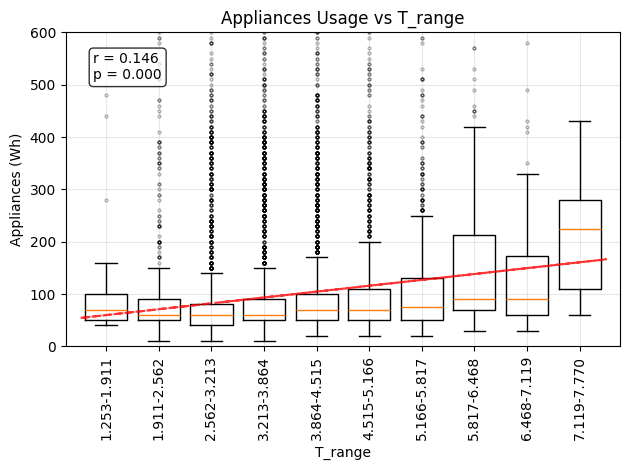

In [8]:
def get_lin_correlated_params(df, p_tresh, r_tresh, target='Appliances'):
    # returns features with best valid linear correlation through pearson 
    good_cols = []
    for col in df.select_dtypes(include=["number"]).columns:
        r, p_value = pearsonr(df[col], df[target])
        if p_value < p_tresh and np.abs(r) > r_tresh and col!=target:
            good_cols.append(col)

    return good_cols

# Let's see how data is broadly distributed.
plot_appliances_histogram(temp_df, percentile_limit=99)
lin_params = get_lin_correlated_params(temp_df, 0.005, 0.1)

# And let's vizualize tendencies for most promising features. 
for param in lin_params:
    plot_appliances_lin(temp_df, param, plot_type='boxplot', y_lim=600)

In [9]:
# These results show that there is little linear correlation between target and features.
# General trends can be observed on the feature level even if a lot of outlier values are present. 
# Two of the most strongly correlated features are engineered ones. This suggests these could be helpful in training the model.
# However given the amount of missing data, engineered features based on averages would be unstable and could mask the model's abilities.
# For that reason, environmental engineered features won't be used for training.
# For simplicity and because of the non-continuous data, the model won't use past predictions. 


# The selected model will need to handle a lack of time continuity and missing data. This choice would justify using GBM and decison trees (here XGBoost).
# They handle non-linear relationships, and are robust to weak correlations. This is supported by our quick litterature review.


### Part Two:

## Data preparationa and Training

In [10]:
# Our dataset will be made of all the raw data that have a target measurement (Appliances).
# We will introduce datetime-based engineered features


def prepare_dataset(df):
    valid_df, _ = remove_no_target_rows(df)
    valid_df = datetime_features(valid_df)

    valid_df = valid_df.drop("date", axis=1)

    return valid_df


valid_df = prepare_dataset(df)


Removed 1151 rows.
Original shape: (17610, 29), New shape: (16459, 29)


In [11]:
# With about 16000 rows, we will split the dataset randomly in a training (80%), validation (10%) and testing (10%) subsets.

from sklearn.model_selection import train_test_split


def split_data_random(
    df, target_col="Appliances", test_size=0.1, val_size=0.1, random_state=42
):

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # separate train and validation from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


In [18]:
# We can now train our XGBoost model
from xgboost import XGBRegressor

def train_xgboost(X_train, X_val, y_train, y_val, params=None, random_state=42):
    
    if params is None:
        params = {
            'n_estimators':  1000,           
            'objective':'reg:absoluteerror',  
            'eval_metric':'mae'
        }

    params['random_state'] = random_state
        
    
    model = XGBRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    return model


def basic_train_random_search(X_train, X_val, y_train, y_val, params=None, model_sampling=10):
    random_states = np.random.randint(1, 1000, model_sampling)


    best_model = None
    best_mae = np.inf

    for rand_state in random_states:
        model = train_xgboost(X_train, X_val, y_train, y_val, params=params, random_state=rand_state)

        mae = model.evals_result()['validation_0']['mae'][-1] 
        print(f"MAE value of model: {mae} Wh.")

        if mae < best_mae:
            best_model=model
            best_mae=mae
    
    print(f"Returning best of {model_sampling} models, with mae of {best_mae} Wh.")
    
    return best_model


# Here are a few parameters selected from intuition and hand tuning.
params = {
            'n_estimators':  3000,           
            'max_depth': 6,
            'early_stopping_rounds': 50,
            'objective':'reg:absoluteerror',  
            'eval_metric':'mae',
            'learning_rate': 0.05,        
            'subsample': 0.8,             # Row sampling
            'colsample_bytree': 0.8,      # Column sampling  
            'min_child_weight': 5,        # Minimum samples in leaf
            'gamma': 0.1,                 # Minimum loss reduction for split
            'reg_alpha': 0.1,             # L1 regularization
            'reg_lambda': 1.0,            # L2 regularization
        }

X_train, X_val, X_test, y_train, y_val, y_test = split_data_random(valid_df)

#We keep the best model from validation set metric evaluation.
model = basic_train_random_search(X_train, X_val, y_train, y_val, params=params, model_sampling=20)
model.save_model("model.json")


[0]	validation_0-mae:50.04268
[100]	validation_0-mae:39.00131
[200]	validation_0-mae:37.55420
[300]	validation_0-mae:36.95801
[400]	validation_0-mae:36.50735
[500]	validation_0-mae:36.25003
[580]	validation_0-mae:36.20402
MAE value of model: 36.20402233674619 Wh.
[0]	validation_0-mae:50.06393
[100]	validation_0-mae:38.99563
[200]	validation_0-mae:37.73426
[300]	validation_0-mae:37.10436
[400]	validation_0-mae:36.82695
[500]	validation_0-mae:36.60434
[600]	validation_0-mae:36.38089
[700]	validation_0-mae:36.26774
[800]	validation_0-mae:36.13751
[900]	validation_0-mae:35.98334
[1000]	validation_0-mae:35.94753
[1100]	validation_0-mae:35.83578
[1200]	validation_0-mae:35.77566
[1300]	validation_0-mae:35.72480
[1400]	validation_0-mae:35.65757
[1425]	validation_0-mae:35.64552
MAE value of model: 35.64592230561291 Wh.
[0]	validation_0-mae:50.05348
[100]	validation_0-mae:38.97827
[200]	validation_0-mae:37.68146
[300]	validation_0-mae:37.02508
[400]	validation_0-mae:36.72247
[499]	validation_0-m

### Part Three:

## Basic Model Testing

5426      90.0
8583      40.0
13460     50.0
3599      60.0
1247     360.0
         ...  
17286    140.0
17411     80.0
14522     60.0
1326      50.0
2189      70.0
Name: Appliances, Length: 1646, dtype: float64


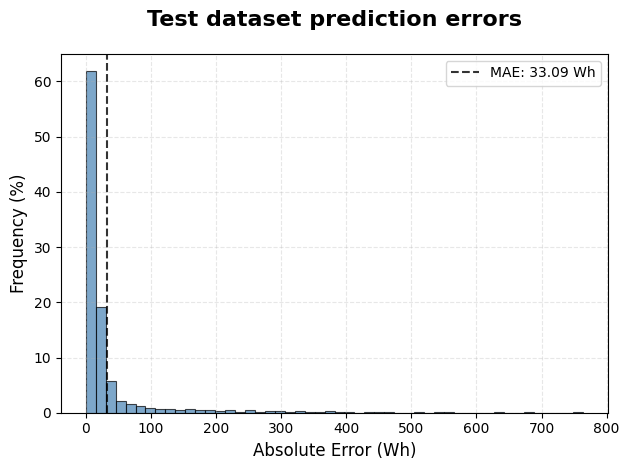

5426      90.0
8583      40.0
13460     50.0
3599      60.0
1247     360.0
         ...  
17286    140.0
17411     80.0
14522     60.0
1326      50.0
2189      70.0
Name: Appliances, Length: 1646, dtype: float64


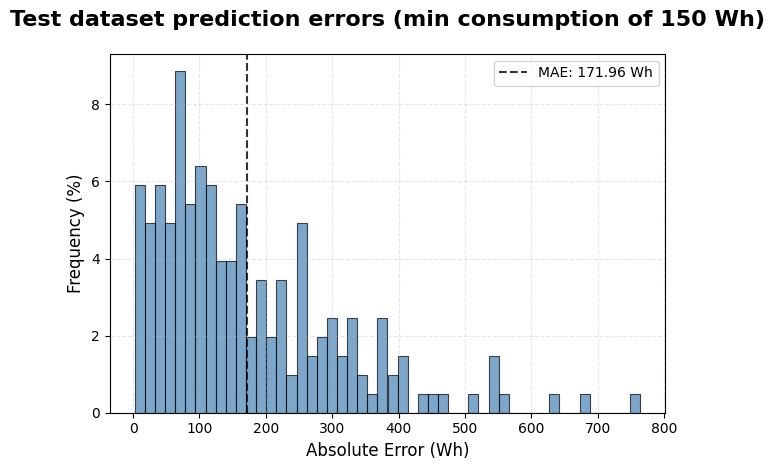

5426      90.0
8583      40.0
13460     50.0
3599      60.0
1247     360.0
         ...  
17286    140.0
17411     80.0
14522     60.0
1326      50.0
2189      70.0
Name: Appliances, Length: 1646, dtype: float64


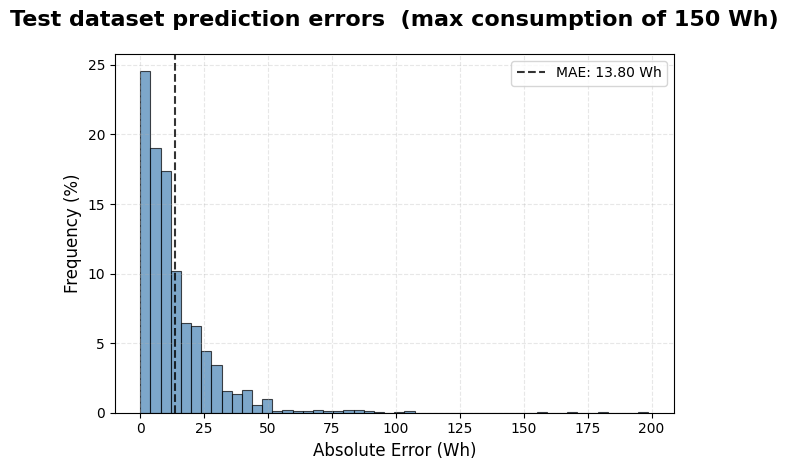

In [22]:
# The model still presents significant error. However, a lot of data is missing, and high energy consumption time might have a large impact over the metric.
# Let's evaluate the predictions the test data.

from sklearn.metrics import mean_absolute_error


def histogram(
    values,
    bins=10,
    title="Histogram",
    xlabel="Absolute Error (Wh)",
    ylabel="Frequency (%)",
    mae=None,
):
    # Simple basic histogram figure with aestetic choices.

    weights = [100.0 / len(values)] * len(values)
    plt.hist(
        values,
        bins=bins,
        weights=weights,
        alpha=0.7,
        color="steelblue",
        edgecolor="black",
        linewidth=0.8,
    )
    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    if mae:
        plt.axvline(
            mae,
            color="black",
            linestyle="--",
            alpha=0.8,
            label=f"MAE: {mae:.2f} Wh",
        )
        plt.legend()

    plt.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()


def filter_between(X, y, min_val, max_val):
    # Filter points from given target range
    indices = y.between(min_val, max_val)
    return X[indices], y[indices]


def evaluate_test_data(model, X_test, y_test, min_val=0, max_val=np.inf):
    print(y_test)
    X_test, y_test = filter_between(X_test, y_test, min_val, max_val)

    y_pred = model.predict(X_test)
    y_diff = abs(y_test - y_pred)

    mae = mean_absolute_error(y_test, model.predict(X_test))

    return y_diff, mae


y_diff, mae = evaluate_test_data(model, X_test, y_test)
histogram(y_diff, bins=50, title="Test dataset prediction errors", mae=mae)

y_diff, mae = evaluate_test_data(model, X_test, y_test, min_val=150)
histogram(
    y_diff,
    bins=50,
    title="Test dataset prediction errors (min consumption of 150 Wh)",
    mae=mae,
)

y_diff, mae = evaluate_test_data(model, X_test, y_test, max_val=150)
histogram(
    y_diff,
    bins=50,
    title="Test dataset prediction errors  (max consumption of 150 Wh)",
    mae=mae,
)


In [23]:
# Looks like our model is performing relatively well for low consumption data, while struggling on usage spikes.
# Considering the missing values and sudden spikes of energy usage in the data, this simple model is performing quite well.
# I would suggest training with a loss function that handles skewed data better (ex.: mean-squared). This would probably worsen results for regular data while allowing better spike predictions. 
# An hybrid approach could be made where a model would be made to only handle abnormal or spike data, while another one is trained for regular usage prediction.



### Part Four:

## Predictions

In [24]:
# Let's now generate predictions for the second dataset


def make_predictions_on_df(model, df):
    temp_df = datetime_features(df)
    temp_df = temp_df.drop(["date", "index"], axis=1)

    predictions_df = pd.DataFrame(
        {
            "index": dataset_2["index"],
            "date": dataset_2["date"],
            "Predictions": model.predict(temp_df),
        }
    )

    predictions_df.set_index("index", inplace=True)

    return predictions_df


# Lets load and prepare our data
dataset_2 = load_dataframe(path="dataset_2.csv")
predictions = make_predictions_on_df(model, dataset_2)
predictions.to_csv("dataset_2_predictions.csv")


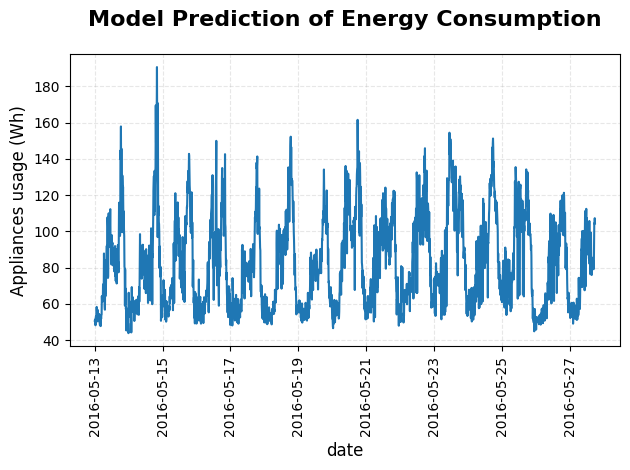

In [25]:
# We can vizualize through time the predictions


def plot_predictions(df):
    plt.plot(predictions["date"], predictions["Predictions"])
    plt.title(
        "Model Prediction of Energy Consumption", fontsize=16, fontweight="bold", pad=20
    )
    plt.xlabel("date", fontsize=12)
    plt.xticks(rotation=90)
    plt.ylabel("Appliances usage (Wh)", fontsize=12)
    plt.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()


plot_predictions(predictions)


In [26]:
#The predictions show relative continuity and time pattern recognition. This is a good sign of good predictions. Unsurprisingly, The model is still bad at predicting sudden spikes.
#Depending on the goal of the model (ex.: global energy needs or spike prevention), the training strategy and parameter choices would be adapted. 
#Better results could probably be obtained with a more complex model making use of potential autocorrelation of data and time continuity (RNN, etc.).